In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import datetime
import time

In [2]:
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

In [3]:
train.head(5)

,Job_ID,Title,Salary,Levels,Analysis skills,Communication skills,Research,R,Machine learning,Bachelor's degree,...,Azure,NoSQL,Master of Science,Windows,Scripting,Marketing,New Relic,DevOps,Computer networking,count
0,0,0,110000,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,10
1,1,1,120000,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,5
2,2,0,150000,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,7
3,3,0,150000,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6
4,4,0,130000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [4]:
target = train['Salary']

In [5]:
del train['Salary']

In [6]:
features = [c for c in train.columns if c not in ['Job_ID']]
categorical_feats = ['Title', 'Levels']

- We then set the hyperparameters of the LGBM model, these parameters are obtained by an `bayesian optimization`.

In [7]:
param = {'num_leavs' : 111,
         'min_data_in_leaf' : 149,
         'objective' : 'regression',
         'max_depth' : 9,
         'learning_rate' : 0.005,
         'boosting' : 'gbdt',
         'feature_fraction' : 0.7522,
         'bagging_freq' : 1,
         'bagging_fraction' : 0.7083,
         'bagging_seed' : 11,
         'metric' : 'rmse',
         'lambda_l1' : 0.2634,
         'random_state' : 133,
         'verbosity' : -1
        }

- We now train the LGBM model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training.

In [8]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
[LightGBM] [Warning] Unknown parameter: num_leavs
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 30143.4	valid_1's rmse: 41125.3
[200]	training's rmse: 29175.6	valid_1's rmse: 40064.8
[300]	training's rmse: 28511.2	valid_1's rmse: 39332.8
[400]	training's rmse: 28164.6	valid_1's rmse: 38950.5
[500]	training's rmse: 27925.5	valid_1's rmse: 38737.5


/Users/justin/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/justin/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/justin/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[600]	training's rmse: 27767.9	valid_1's rmse: 38595.4
[700]	training's rmse: 27592.4	valid_1's rmse: 38475.8
[800]	training's rmse: 27471.2	valid_1's rmse: 38405
[900]	training's rmse: 27367.5	valid_1's rmse: 38356.4
[1000]	training's rmse: 27295.1	valid_1's rmse: 38312.2
[1100]	training's rmse: 27215.2	valid_1's rmse: 38288.7
[1200]	training's rmse: 27154.8	valid_1's rmse: 38275.5
[1300]	training's rmse: 27101.8	valid_1's rmse: 38255.7
[1400]	training's rmse: 27042.6	valid_1's rmse: 38240.1
[1500]	training's rmse: 26984.7	valid_1's rmse: 38205.8
[1600]	training's rmse: 26940.1	valid_1's rmse: 38178.8
[1700]	training's rmse: 26909.7	valid_1's rmse: 38170.6
[1800]	training's rmse: 26862.9	valid_1's rmse: 38146
[1900]	training's rmse: 26835.2	valid_1's rmse: 38136.8
[2000]	training's rmse: 26791.1	valid_1's rmse: 38109
[2100]	training's rmse: 26767.5	valid_1's rmse: 38105.2
[2200]	training's rmse: 26739.6	valid_1's rmse: 38102.3
[2300]	training's rmse: 26701.5	valid_1's rmse: 38083.1
[2

[5800]	training's rmse: 28105	valid_1's rmse: 21983.6
[5900]	training's rmse: 28079.3	valid_1's rmse: 21964.2
[6000]	training's rmse: 28054	valid_1's rmse: 21936
[6100]	training's rmse: 28025.9	valid_1's rmse: 21925.9
[6200]	training's rmse: 27999.8	valid_1's rmse: 21905.1
[6300]	training's rmse: 27972.3	valid_1's rmse: 21894.3
[6400]	training's rmse: 27945.2	valid_1's rmse: 21864
[6500]	training's rmse: 27920.8	valid_1's rmse: 21846.7
[6600]	training's rmse: 27890.3	valid_1's rmse: 21867.1
Early stopping, best iteration is:
[6495]	training's rmse: 27922.5	valid_1's rmse: 21843.9
fold n°2
[LightGBM] [Warning] Unknown parameter: num_leavs
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 33370.5	valid_1's rmse: 29235.7
[200]	training's rmse: 32403.9	valid_1's rmse: 28252.6
[300]	training's rmse: 31702.8	valid_1's rmse: 27560.2
[400]	training's rmse: 31312.1	valid_1's rmse: 27141.1
[500]	training's rmse: 31055.7	valid_1's rmse: 26839.1
[600]	training's 

[800]	training's rmse: 29187.4	valid_1's rmse: 32440.8
[900]	training's rmse: 29082.5	valid_1's rmse: 32378.5
[1000]	training's rmse: 28997.4	valid_1's rmse: 32327.4
[1100]	training's rmse: 28893.5	valid_1's rmse: 32250.6
[1200]	training's rmse: 28806.4	valid_1's rmse: 32179.3
[1300]	training's rmse: 28718.7	valid_1's rmse: 32097.1
[1400]	training's rmse: 28625.1	valid_1's rmse: 31997.1
[1500]	training's rmse: 28531.3	valid_1's rmse: 31904
[1600]	training's rmse: 28450.2	valid_1's rmse: 31827.6
[1700]	training's rmse: 28371.6	valid_1's rmse: 31747.8
[1800]	training's rmse: 28284.8	valid_1's rmse: 31667
[1900]	training's rmse: 28215	valid_1's rmse: 31589.2
[2000]	training's rmse: 28144.1	valid_1's rmse: 31513.3
[2100]	training's rmse: 28066.2	valid_1's rmse: 31428.1
[2200]	training's rmse: 27985.9	valid_1's rmse: 31349.2
[2300]	training's rmse: 27904	valid_1's rmse: 31264.1
[2400]	training's rmse: 27847.5	valid_1's rmse: 31220
[2500]	training's rmse: 27789.2	valid_1's rmse: 31144.1
[260

In [9]:
sub_df = pd.DataFrame({"Job_ID" : test["Job_ID"].values})
sub_df["target"] = predictions
sub_df.to_csv("pred.xlsx", index = False)

- Finally, we can have a look at the features that were used by the model.

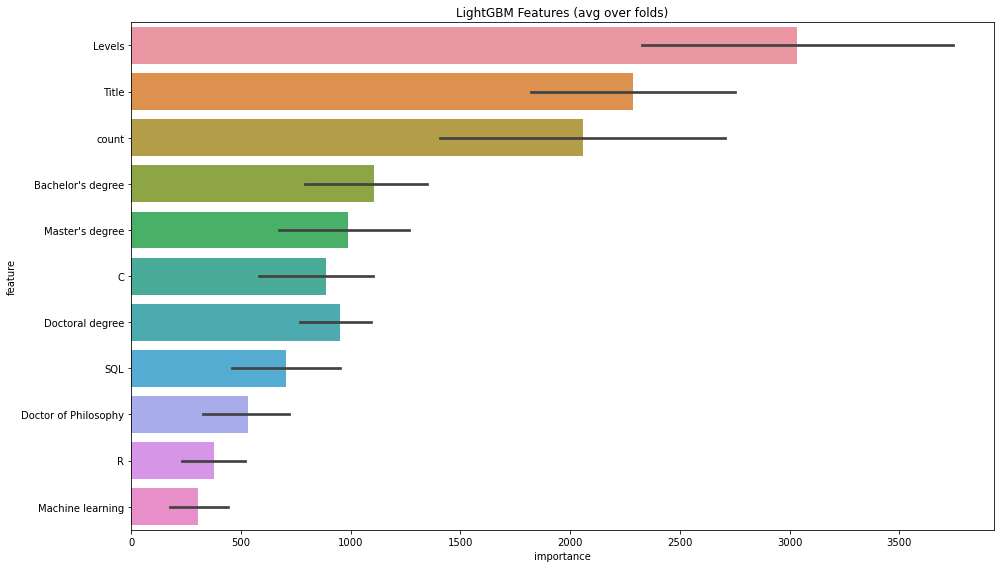

In [10]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:11].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14, 8))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [11]:
print("CV score: {:<8.5f}".format(mean_squared_error(predictions, test['Salary'])**0.5))

CV score: 25052.96620
